# Warehouse Dataset Cleanup
## Library Setup

The main objective of this project is to clean and transform a dataset containing warehouse data and prepare it to be analysed. The libraries we'll use for this is pandas and seaborn.

In [1]:
import pandas as pd
from word2number import w2n
import seaborn as sns

sns.set_theme(style="whitegrid", palette="colorblind")

## Load data

To enable manipulation of the data we'll load the dataset into a pandas DataFrame object and perform a preliminary assessment of the data structure.

In [2]:
path = "https://raw.githubusercontent.com/usernameneo/Data-Science-Projects/refs/heads/main/EDA/Warehouse/data/warehouse_messy_data.csv"
df = pd.read_csv(path)

df.shape

(1000, 10)

In [3]:
df.head()

,Product ID,Product Name,Category,Warehouse,Location,Quantity,Price,Supplier,Status,Last Restocked
0,1102,gadget y,ELECTRONICS,Warehouse 2,Aisle 1,300,9.99,Supplier C,In Stock,NaN
1,1435,gadget y,ELECTRONICS,Warehouse 2,Aisle 4,two hundred,19.99,Supplier C,Out of Stock,NaN
2,1860,widget a,CLOTHING,Warehouse 2,Aisle 3,100,19.99,Supplier B,In Stock,20/12/2022
3,1270,gadget z,TOYS,Warehouse 2,Aisle 4,50,49.99,Supplier B,In Stock,20/12/2022
4,1106,widget a,FURNITURE,Warehouse 3,Aisle 3,two hundred,9.99,Supplier D,Out of Stock,25/04/2023


In [4]:
df.tail()

,Product ID,Product Name,Category,Warehouse,Location,Quantity,Price,Supplier,Status,Last Restocked
995,1009,widget b,FURNITURE,Warehouse 2,Aisle 2,100,NaN,Supplier C,In Stock,15/01/2023
996,1823,gadget y,ELECTRONICS,Warehouse 2,Aisle 3,300,19.99,Supplier B,In Stock,20/12/2022
997,1797,gadget z,TOYS,Warehouse 3,Aisle 5,150,9.99,Supplier C,Low Stock,05/03/2023
998,1241,widget c,FURNITURE,Warehouse 2,Aisle 2,100,49.99,Supplier C,Low Stock,20/12/2022
999,1250,widget a,CLOTHING,Warehouse 1,Aisle 3,100,49.99,Supplier B,Out of Stock,20/12/2022


In [5]:
df.dtypes

Product ID          int64
Product Name       object
Category           object
Warehouse          object
Location           object
Quantity           object
Price             float64
Supplier           object
Status             object
Last Restocked     object
dtype: object

## Data Cleaning

From the pleliminary structural assessment, we can see that the dataframe we'll be working with is 10 columns wide and 1,000 records deep. Issues we'll need to address are the meaningless values in Product Name, input inconsistencies in Quantity, and missing values in Price and Last Restocked. The data types for most of the columns are string, we need to convert numerical and date columns to appropriate data types.

We'll first remove Product Name, and rename Product ID and Last Restocked to ID and Restocked to ensure our dataframe consists of meaningful and consise data.

In [6]:
df = df.drop(["Product Name"], axis=1)
df.columns

Index(['Product ID', 'Category', 'Warehouse', 'Location', 'Quantity', 'Price',
       'Supplier', 'Status', 'Last Restocked'],
      dtype='object')

In [7]:
df = df.rename(columns={"Product ID": "ID", "Last Restocked": "Restocked"})
df.columns

Index(['ID', 'Category', 'Warehouse', 'Location', 'Quantity', 'Price',
       'Supplier', 'Status', 'Restocked'],
      dtype='object')

Data duplication is unlikely given the type of records being stored, however, we will perform an assessment to verify that there no duplicate records and handle them appropriately if any are present in our data.

In [8]:
print(f"Duplicate Records: {df.duplicated().sum()}")

Duplicate Records: 0


Next we'll identify where all missing values in our data are located by counting all non-NA values for each column and row.

In [9]:
df.isna().sum()

ID             0
Category       0
Warehouse      0
Location       0
Quantity     158
Price        207
Supplier       0
Status         0
Restocked    200
dtype: int64

### Quantity

The Quantity field has three issues, missing values, incorrect data type and incosistancy. We'll rectify these issues as follows:
1. Correct inconsistency by converting all worded entries to their numerical couterpart, enabling data type conversion. We'll define a function to parse each record and covert each worded value.
2. Convert the column to an integer data type, int64. This is the most appropriate because you cannot typically acquire 1.5 items.
3. Lastly we'll fill in missing values with the average for that category of item.

In [10]:
def convert_to_digits(value):
    if pd.isna(value):
        return value
    
    str_value = str(value).strip().lower()
    
    try:
        return int(float(str_value))
    except ValueError:
        try:
            return w2n.word_to_num(str_value)
        except ValueError:
            return pd.NA

df.Quantity = round(df["Quantity"].apply(convert_to_digits)).astype("Int64")
df.dtypes

ID             int64
Category      object
Warehouse     object
Location      object
Quantity       Int64
Price        float64
Supplier      object
Status        object
Restocked     object
dtype: object

The mean of the Quantity and Price columns will be a float value, so we'll round it off to cenvert it to an integer.

In [11]:
category_quantity_ave = round(df.groupby("Category")["Quantity"].mean())
df.Quantity = df.Quantity.fillna(df["Category"].map(category_quantity_ave))
df.count()

ID           1000
Category     1000
Warehouse    1000
Location     1000
Quantity     1000
Price         793
Supplier     1000
Status       1000
Restocked     800
dtype: int64

### Price

In [12]:
category_price_ave = round(df.groupby("Category")["Price"].mean())
df.Price = df.Price.fillna(df["Category"].map(category_price_ave))
df.count()

ID           1000
Category     1000
Warehouse    1000
Location     1000
Quantity     1000
Price        1000
Supplier     1000
Status       1000
Restocked     800
dtype: int64

### Restocked

Missing values will raise an error in we attempt to convert them into datetime format. To address this, we coerce these values to a missing value format meant for datetime objects.

In [13]:
df.Restocked = pd.to_datetime(df.Restocked, errors="coerce")
df.head(10)

/tmp/ipykernel_72421/2048096838.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.Restocked = pd.to_datetime(df.Restocked, errors="coerce")


,ID,Category,Warehouse,Location,Quantity,Price,Supplier,Status,Restocked
0,1102,ELECTRONICS,Warehouse 2,Aisle 1,300,9.99,Supplier C,In Stock,NaT
1,1435,ELECTRONICS,Warehouse 2,Aisle 4,200,19.99,Supplier C,Out of Stock,NaT
2,1860,CLOTHING,Warehouse 2,Aisle 3,100,19.99,Supplier B,In Stock,2022-12-20
3,1270,TOYS,Warehouse 2,Aisle 4,50,49.99,Supplier B,In Stock,2022-12-20
4,1106,FURNITURE,Warehouse 3,Aisle 3,200,9.99,Supplier D,Out of Stock,2023-04-25
5,1071,CLOTHING,Warehouse 3,Aisle 5,300,28.00,Supplier A,In Stock,2022-12-20
6,1700,CLOTHING,Warehouse 2,Aisle 2,200,49.99,Supplier B,In Stock,2022-12-20
7,1020,CLOTHING,Warehouse 1,Aisle 5,200,9.99,Supplier D,Out of Stock,2022-12-20
8,1614,ELECTRONICS,Warehouse 3,Aisle 3,300,9.99,Supplier B,Out of Stock,2023-03-05
9,1121,TOYS,Warehouse 1,Aisle 2,50,19.99,Supplier C,Out of Stock,2022-12-20


Lastly, assuming that items are restocked on a regular basis, we'll use the median date to fill in any missing values in Restocked.

In [14]:
median_date = df.Restocked.median()
df.Restocked = df.Restocked.fillna(median_date)
df.Restocked.count()

np.int64(1000)

## Preliminary analysis
### Five Number Summary

In [15]:
df.describe(exclude=["int64", "datetime64[ns]", "object"])

,Price
count,1000.000000
mean,28.059070
std,13.080488
min,9.990000
25%,19.990000
50%,28.000000
75%,29.990000
max,49.990000


### Outliers

<Axes: xlabel='Price'>

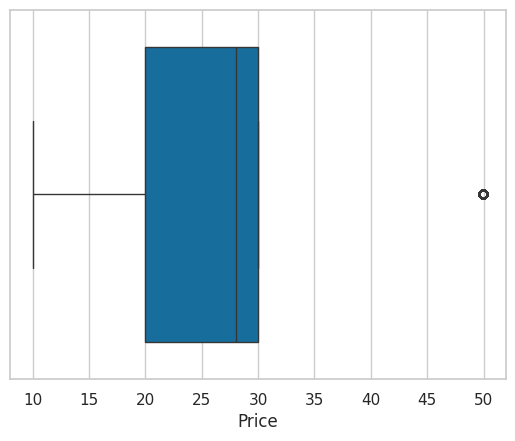

In [16]:
sns.boxplot(x=df.Price)

<Axes: xlabel='Quantity'>

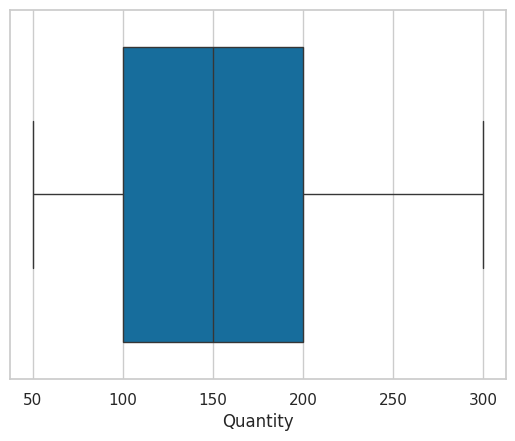

In [17]:
sns.boxplot(x=df.Quantity)